# **ANEXOS**

En este primer ANEXO se incluye los modelos LSTM y Random Forest

# Librerias

In [46]:
# ------------------------------
# Configuración de warnings
# ------------------------------
import warnings
warnings.filterwarnings('ignore')

# ------------------------------
# TensorFlow y Keras
# ------------------------------
import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping

# ------------------------------
# Manipulación de datos
# ------------------------------
import numpy as np
import pandas as pd
from numpy import array, asarray
from pandas import DataFrame, concat

# ------------------------------
# Descarga de datos financieros
# ------------------------------
import yfinance as yf
from pandas_datareader import data as pdr

# ------------------------------
# Visualización
# ------------------------------
import matplotlib.pyplot as plt
import plotly.graph_objects as go
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
# %matplotlib inline  # <-- Solo si estás en Jupyter

# ------------------------------
# Modelado y pronóstico
# ------------------------------
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster, backtesting_forecaster
from skforecast.utils import save_forecaster, load_forecaster

from joblib import dump, load
from datetime import datetime
from math import sqrt


# **PASO 1:Aplicación de los modelos**

### **1. Descarga de Yahoo Finance la serie de precios de cierre del activo META en las fechas: 01-05-2016 al 28-01-2018.**

In [47]:
import pandas as pd

# Leer los datos desde el archivo CSV
meta = pd.read_csv('META_datos_completos.csv')[['Close', 'Date']]
dt = meta
dt['Date'] = pd.to_datetime(dt['Date'])

dt = dt.set_index('Date')

dt.columns = ['META']

# Ahora agregamos el encabezado 'Ticker' para que quede el formato que buscas
dt.columns.name = 'Ticker'


### **2. Grafica la serie**

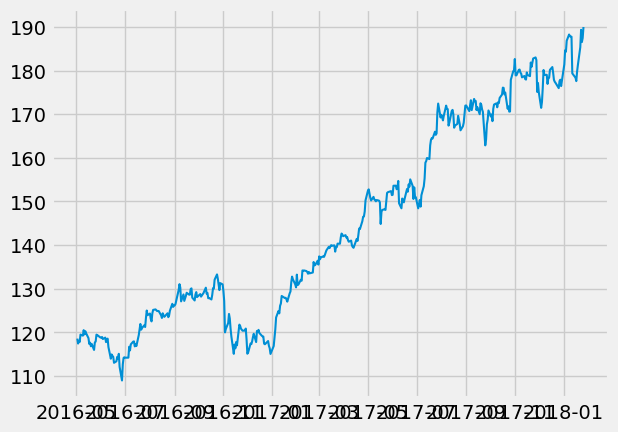

In [48]:
#Una vez llamada la librería, graficamos la serie dt.
import matplotlib.pyplot as plt
plt.plot(dt)

### **3. Prepara los datos a manera que cuentes con un formato adecuado para la fecha.**

In [49]:
#Ahora, pasamos el data frame a un objeto de tiempo de pandas.
dataindex= pd.to_datetime(dt.index)
#Ahora, a numpy array:
dt2= dt.to_numpy()
#Y generamos un rearreglo de la dimensión del array a 1D, en los renglones (el -1 signigica que numpy calcula este número por nosotros).
close_data = dt2.reshape((-1,1))

### **4. Parte la serie a un 5% de prueba y el restante para el entrenamiento.**

In [50]:
#Especificamos primeramente el porcentje del corte.
split_percent = 0.95
split = int(split_percent*len(close_data))

#Aplicamos dicha proporción a la definición de la parte de entrenamiento y de prueba.
close_train = close_data[:split]
close_test = close_data[split:]

date_train = dataindex[:split]
date_test = dataindex[split:]

### **5. Realiza el preprocesamiento necesario para aplicar cada uno de los modelos**

**5.1 Preprocesamiento LSTM**

In [51]:
#Especificamos la longitud o length, es el número de observaciones tipo lags a emplear en la prción de entrada de cada muestra, el ejemplo anterior era de 3.
n_back = 10   #la longitud de la ventana
train_generator = TimeseriesGenerator(close_train, close_train, length=n_back, batch_size=25)
test_generator = TimeseriesGenerator(close_test, close_test, length=n_back, batch_size=1)

**5.1 Preprocesamiento RF**

In [52]:
## Imputamos algún valor faltante con el valor anterior.
dt.fillna(method='bfill', inplace=True)
dt= dt.rename(columns={'META': 'y'})

# Split data into train-test
# ==============================================================================
split_percent = 0.052
steps = int(split_percent*len(close_data))
#steps = 100
data_train = dt[:-steps]
data_test  = dt[-steps:]
print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

#Así también para las fechas:
date_train = dataindex[:-steps]
date_test = dataindex[-steps:]

Train dates : 2016-05-02 00:00:00 --- 2017-12-22 00:00:00  (n=417)
Test dates  : 2017-12-26 00:00:00 --- 2018-01-26 00:00:00  (n=22)


### **6. Aplica cada uno de los modelos MARS, LSTM, RF y SSA a la serie de META**

**6.1 LSTM**

In [53]:
##Neural Net
#Importamos primero los módulos requeridos:
from keras.models import Sequential
from keras.layers import LSTM, Dense

#Configuramos la de red.
model = Sequential()
model.add(
    LSTM(200,  ## de nodos, dependerá de su poder de cómputo.
        activation='relu',
        input_shape=(n_back,1))   ##la longitud de la secuencia
)
model.add(Dense(1))  #capa de salida de predicción
model.compile(optimizer='adam', loss='mse')

num_epochs = 30
# Use model.fit instead of model.fit_generator
model.fit(train_generator, epochs=num_epochs, verbose=0)

##Ajuste del modelo a los datos:
history = model.fit(train_generator, epochs=num_epochs, verbose=0)

In [54]:
#Imprimimos gráfico de funión de pérdida acorde los epochs
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

plot_data = [
    go.Scatter(
        x=hist['epoch'],
        y=hist['loss'],
        name='loss'
    )
]

plot_layout = go.Layout(
        title='Training loss')
fig = go.Figure(data=plot_data, layout=plot_layout)
fig.show()

**6.1 RF**

In [55]:
# Creamos y entrenamos el modelo de Random Forest con la función de estructura de datos generada a través de la función Forecaster, en este caso, creando ventanas de 10 días:
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags = 15
                )

forecaster.fit(y=data_train['y'])

### **7. Empleando tus resultados, calcula las métricas para la medición de asertividad de un pronóstico, al menos debescalcular dos métricos de error de pronóstico, ejemplo: MAPE, RMSE, MAE, entre otros.**

## Validacion desempeño del modelo

**7.1 Validacion en conjunto de test con LSTM**

In [56]:
# Extraer los valores reales del test set
input_data = close_data
output_data = close_data

y_true = output_data[split + n_back:]  # Para alinear con la longitud de las predicciones

# Hacer las predicciones
y_pred = model.predict(test_generator)

# Calcular métricas
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape * 100:.2f}%")



12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
RMSE: 4.332173022692807
MAE: 3.818679504394533
MAPE: 2.09%


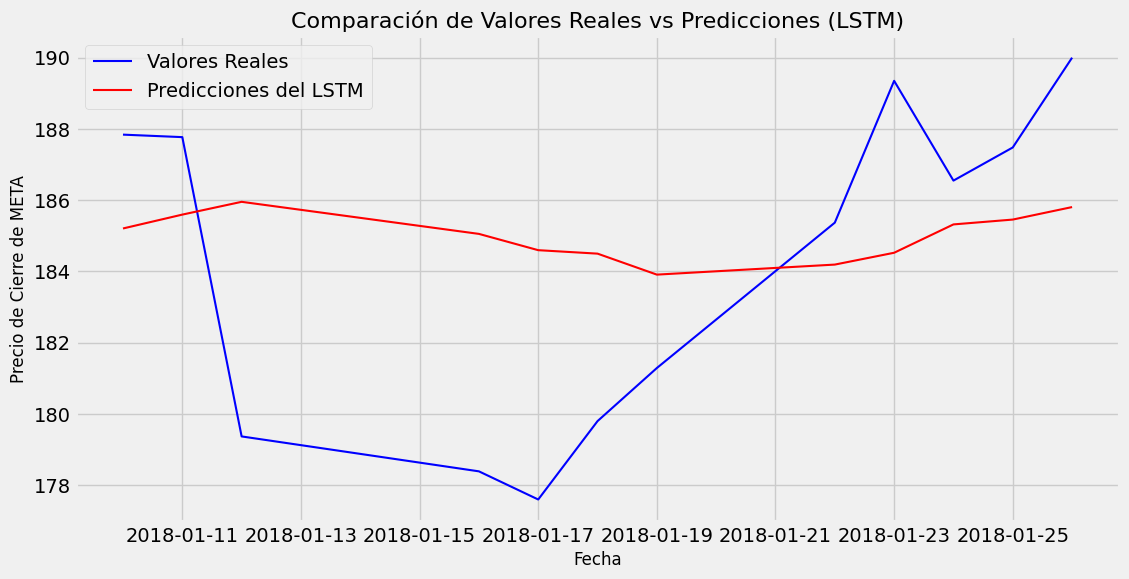

In [57]:
# Grafica los valores reales y las predicciones
plt.figure(figsize=(12, 6))
plt.plot(date_test[n_back:], y_true, label='Valores Reales', color='blue')  # Valores reales
plt.plot(date_test[n_back:], y_pred, label='Predicciones del LSTM', color='red')  # Predicciones

# Añadir título y etiquetas
plt.title('Comparación de Valores Reales vs Predicciones (LSTM)', fontsize=16)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Precio de Cierre de META', fontsize=12)
plt.legend()

# Mostrar la gráfica
plt.grid(True)
plt.show()


**7.1 Validacion en conjunto de test con RF**

In [31]:
# Determinamos el error de pronóstico:
# Pronóstico, en este caso elegimos una ventana de n-test días.
# ==============================================================================
steps = steps  ## el mismo que la ventana de test
predictions = forecaster.predict(steps=steps)

# ==============================================================================
# Calcula métricas
rmse = sqrt(mean_squared_error(data_test['y'], predictions))
mae = mean_absolute_error(data_test['y'], predictions)
mape = mean_absolute_percentage_error(data_test['y'], predictions) * 100  # en porcentaje

# Muestra resultados
print(f"Test error (RMSE): {rmse}")
print(f"Test error (MAE): {mae}")
print(f"Test error (MAPE): {mape}%")

Test error (RMSE): 6.15054444921891
Test error (MAE): 5.119609090909063
Test error (MAPE): 2.751584137094789%


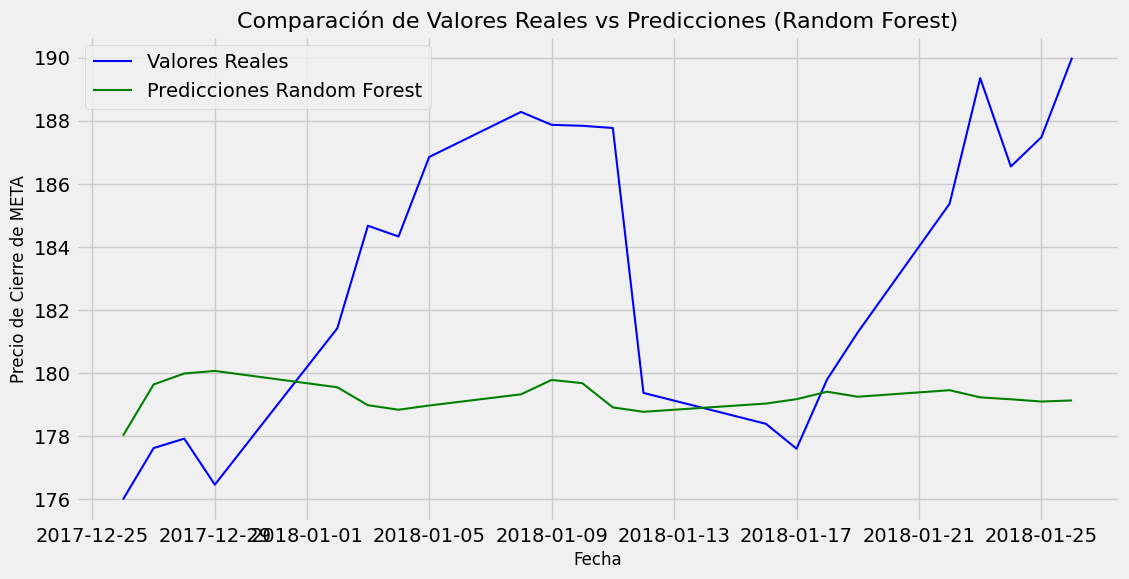

In [69]:
# Grafica los valores reales y las predicciones
plt.figure(figsize=(12, 6))

# Graficar los valores reales de la serie de tiempo
plt.plot(date_test, data_test['y'], label='Valores Reales', color='blue')

# Graficar las predicciones del modelo
plt.plot(date_test, predictions, label='Predicciones Random Forest', color='green')

# Añadir título y etiquetas
plt.title('Comparación de Valores Reales vs Predicciones (Random Forest)', fontsize=16)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Precio de Cierre de META', fontsize=12)

# Mostrar la leyenda
plt.legend()

# Mostrar la gráfica
plt.grid(True)
plt.show()

# **PASO 2:Comparación de los modelos y selección del mejor**

**1. Compara y sustenta qué modelo presentó un mejor desempeño de acuerdo a los criterios de selección pertinentes.**

| Modelo         | RMSE    | MAE    | MAPE (%) |
|----------------|---------|--------|----------|
| MARS           | 19.45   | 18.77  | 10.14    |
| LSTM           | 4.33    | 3.82   | 2.09     |
| Random Forest  | 6.15    | 5.12   | 2.75     |
| SSA            | 5.48    | 4.69   | 2.59     |

En base a las métricas obtenidas, el modelo LSTM muestra el mejor desempeño en términos de RMSE, MAE y MAPE, superando a los demás modelos con un RMSE de 4.33, MAE de 3.82 y un MAPE de 2.09%. Este desempeño es notablemente mejor en comparación con el modelo MARS (RMSE: 19.45, MAPE: 10.14%) y Random Forest (RMSE: 6.15, MAPE: 2.75%). Sin embargo, el modelo SSA también tiene buenos resultados con un MAPE de 2.59%, aunque sigue siendo menos preciso que el LSTM. Estos resultados sugieren que los modelos basados en redes neuronales, como el LSTM, pueden capturar mejor las complejas relaciones temporales en los datos de precios de acciones, mientras que los modelos más simples, como MARS y Random Forest, no logran igualar la precisión

**2. Genera un pronóstico de 10 días hacia adelante y una visualización del mismo**

In [108]:
input_data = close_data
output_data = close_data

def optimize_lstm_univariate(input_data, output_data, dataindex,
                             n_back=10, split_percent=0.9,
                             batch_size=32, max_trials=10, epochs=25,
                             fast_mode=False):

    if fast_mode:
        max_trials = 2
        epochs = 15
        print(" MODO RÁPIDO ACTIVADO: max_trials=2, epochs=15")

    split = int(split_percent * len(output_data))

    # Generadores
    train_generator = TimeseriesGenerator(input_data[:split], output_data[:split],
                                          length=n_back, batch_size=batch_size)
    test_generator = TimeseriesGenerator(input_data[split:], output_data[split:],
                                         length=n_back, batch_size=1)

    def build_model(hp):
        model = Sequential()
        units = hp.Int('units', min_value=32, max_value=300 if fast_mode else 256, step=32)
        dropout_rate = hp.Float('dropout', min_value=0.1, max_value=0.3 if fast_mode else 0.5, step=0.1)

        model.add(LSTM(units, activation='relu', return_sequences=True, input_shape=(n_back, 1)))
        model.add(Dropout(dropout_rate))
        model.add(LSTM(units // 2, activation='relu'))
        model.add(Dropout(dropout_rate))
        model.add(Dense(1))  # Predicción univariada

        optimizer_choice = hp.Choice('optimizer', ['adam', 'rmsprop'])
        optimizer = Adam() if optimizer_choice == 'adam' else RMSprop()

        model.compile(optimizer=optimizer, loss='mse')
        return model

    tuner = kt.RandomSearch(
        build_model,
        objective='val_loss',
        max_trials=max_trials,
        executions_per_trial=1,
        directory='lstm_tuning',
        project_name='amzn_univariate'
    )

    tuner.search(train_generator, validation_data=test_generator, epochs=epochs, verbose=1)

    best_model = tuner.get_best_models(num_models=1)[0]
    best_hp = tuner.get_best_hyperparameters(1)[0]

    print(" Mejores hiperparámetros encontrados:")
    for k, v in best_hp.values.items():
        print(f"  {k}: {v}")

    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = best_model.fit(
        train_generator,
        validation_data=test_generator,
        epochs=50 if not fast_mode else 10,
        callbacks=[early_stop],
        verbose=1
    )

    return best_model, best_hp

best_model, best_hp = optimize_lstm_univariate(
    input_data=input_data,
    output_data=output_data,
    dataindex=dataindex,
    n_back=10,
    batch_size=50,  ## si no hay tiempo, pueden bajar este parámetro
    max_trials=10,
    epochs=10,
    fast_mode=True  # Puedes cambiar a True para búsqueda completa
)

close_data = dt2.reshape(-1)  # <--- esto es clave, si no, el pronóstico queda achatado, en otras dimensiones que le dió el reshape.

# Reconstruir el modelo optimizado en el modo FAST--
rebuilt_model = build_model(best_hp)
rebuilt_model.set_weights(best_model.get_weights())
_ = rebuilt_model.predict(np.zeros((1, n_back, 1), dtype=np.float32))


# 3] Asegurar que close_data esté en 1D ---
close_data = dt2.reshape(-1)  # ¡aquí va lo que preguntaste!

# 4] Definir predict() ---
def predict(num_prediction, model):
    prediction_list = close_data[-n_back:]
    for _ in range(num_prediction):
        x = prediction_list[-n_back:]
        x = x.reshape((1, n_back, 1)).astype(np.float32)
        out = model.predict(x, verbose=0)[0][0]
        prediction_list = np.append(prediction_list, out)
    return prediction_list[n_back-1:]

# --- [5] Generar forecast y graficar ---
forecast = predict(10, rebuilt_model)

def predict_dates(num_prediction):
    last_date = dataindex[-1]
    return pd.date_range(start=last_date + pd.Timedelta(days=1), periods=num_prediction)

forecast_dates = predict_dates(10)

#Fechas, 10 días pegado al histórico:
def predict(num_prediction, model):
    prediction_list = close_data[-n_back:]

    for _ in range(num_prediction):
        x = prediction_list[-n_back:]
        x = x.reshape((1, n_back, 1)).astype(np.float32)
        out = model.predict(x, verbose=0)[0][0]
        prediction_list = np.append(prediction_list, out)

    return prediction_list[n_back-1:]  # solo forecast (sin la parte usada como entrada)

num_prediction = 10
forecast = predict(num_prediction, rebuilt_model)



 MODO RÁPIDO ACTIVADO: max_trials=2, epochs=15
Reloading Tuner from lstm_tuning/amzn_univariate/tuner0.json
 Mejores hiperparámetros encontrados:
  units: 64
  dropout: 0.1
  optimizer: adam
Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 1052.0535 - val_loss: 232.3014
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1013.2159 - val_loss: 36.4303
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 886.8623 - val_loss: 144.0780
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 723.8525 - val_loss: 39.5540
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 669.3236 - val_loss: 50.2292
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 703.8141 - val_loss: 479.4458
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 783.4880 - val_loss: 71.2362
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


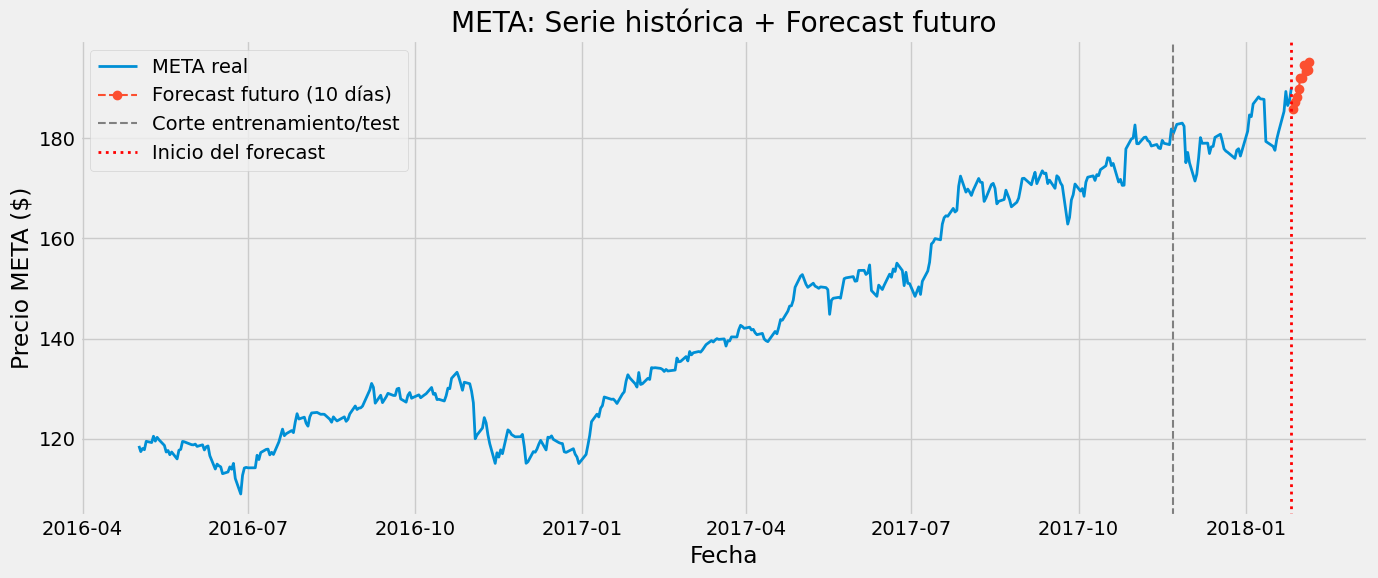

In [111]:
#Fecha de corte (80%)
split = int(0.9 * len(close_data))

# Asegurar que `forecast` tenga la longitud correcta (10 en este caso)
forecast = forecast[-10:]  # Ajustar la longitud de forecast

# Gráfico
plt.figure(figsize=(14, 6))

# 1. Serie histórica
plt.plot(dataindex, close_data, label='META real', linewidth=2)

# 2. Forecast futuro
plt.plot(forecast_dates, forecast, label='Forecast futuro (10 días)', linestyle='--', marker='o')

# 3. Línea vertical: corte entre entrenamiento y test
plt.axvline(x=dataindex[split], color='gray', linestyle='--', linewidth=1.5, label='Corte entrenamiento/test')

# 4. Línea vertical: inicio del forecast (último día conocido)
plt.axvline(x=dataindex[-1], color='red', linestyle=':', linewidth=2, label='Inicio del forecast')

# Estética
plt.title('META: Serie histórica + Forecast futuro')
plt.xlabel('Fecha')
plt.ylabel('Precio META ($)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

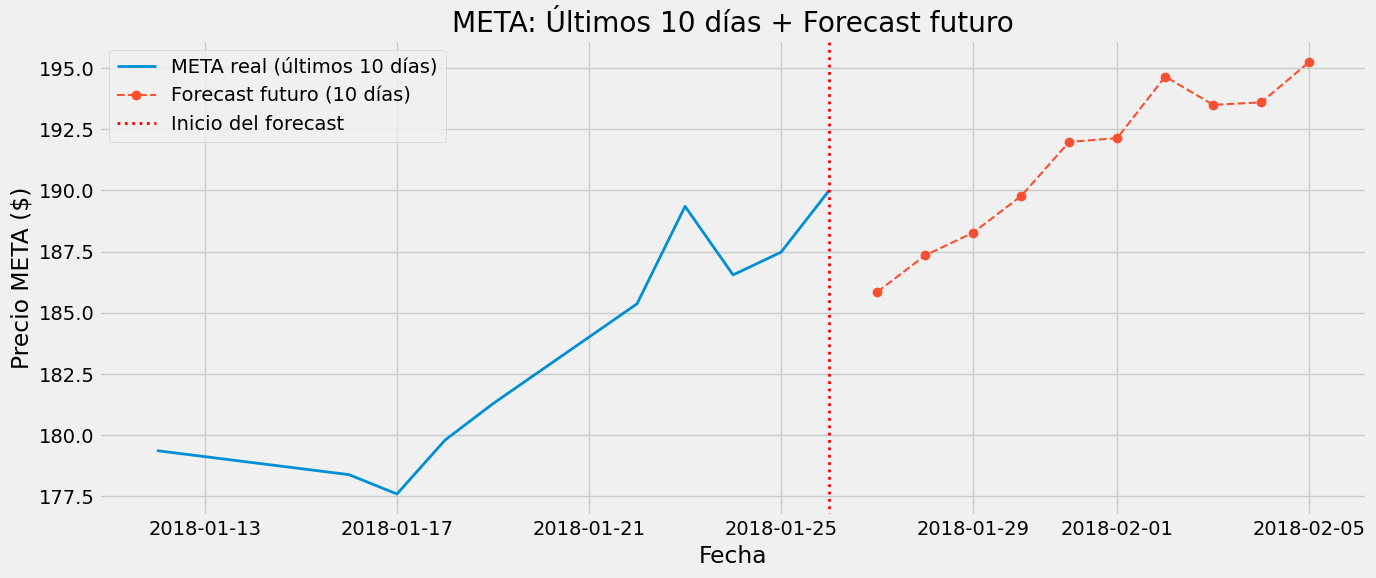

In [115]:

# Últimos 10 días históricos
n_recent = 10
recent_dates = dataindex[-n_recent:]
recent_values = close_data[-n_recent:]

# Asegurar forecast tenga longitud 10
forecast = forecast[-10:]  # por si tiene más
forecast_dates = forecast_dates[:10]  # asegurar que coincide

# Gráfico
plt.figure(figsize=(14, 6))

# 1. Últimos 30 días reales
plt.plot(recent_dates, recent_values, label='META real (últimos 10 días)', linewidth=2)

# 2. Forecast futuro
plt.plot(forecast_dates, forecast, label='Forecast futuro (10 días)', linestyle='--', marker='o')

# 3. Línea vertical: inicio del forecast
plt.axvline(x=dataindex[-1], color='red', linestyle=':', linewidth=2, label='Inicio del forecast')

# Estética
plt.title('META: Últimos 10 días + Forecast futuro')
plt.xlabel('Fecha')
plt.ylabel('Precio META ($)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
